In [49]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis_edit as spike

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'omission'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
Please

In [50]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [51]:
rewarded_df = spike_analysis.wilcox_baseline_v_event_collection('rewarded', 10, 10, plot=False)
win_df = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10, plot=False)
lose_df = spike_analysis.wilcox_baseline_v_event_collection('lose', 10, 10, plot=False)

Wilcoxon can't be done on 20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec rewarded, because <6 samples
Wilcoxon can't be done on 20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec rewarded, because <6 samples
Wilcoxon can't be done on 20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec win, because <6 samples
Wilcoxon can't be done on 20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec win, because <6 samples
Wilcoxon can't be done on 20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec win, because <6 samples
Wilcoxon can't be done on 20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec win, because <6 samples
Wilcoxon can't be done on 20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec lose, because <6 samples
Wilcoxon can't be done on 20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec los

In [52]:
def normalize_event_string(event_string):
        event_list = event_string.split(', ')
        event_list_sorted = sorted(event_list)  # Sort the list to ensure consistent order
        return ', '.join(event_list_sorted)  # Join the sorted list back into a string

def aggregate_event_data(combined_df):
    # Function to extract just the event name
    def extract_event_name(event):
        # Remove any leading time duration from the event string
        parts = event.split(' vs ')
        event_name = parts[0].split(' ')[-1]  # Splits by space and takes the last part, removing any time prefix
        return event_name

    # Initialize an empty dictionary to hold aggregated data
    aggregated_data = {}

    # Iterate over the rows of the combined DataFrame
    for index, row in combined_df.iterrows():
        # Extract event name
        event_name = extract_event_name(row['Event'])
        # Construct a unique key for each combination of recording, subject, and unit id
        key = (row['Recording'], row['Subject'], row['original unit id'])
        
        # Initialize the entry if not exists
        if key not in aggregated_data:
            aggregated_data[key] = {'sig_increase_events': set(), 'sig_decrease_events': set(), 'insig_events': set()}
        
        # Append the event name to the appropriate category based on 'event1 vs event2'
        if row['event1 vs event2'] == 'increases':
            aggregated_data[key]['sig_increase_events'].add(event_name)
        elif row['event1 vs event2'] == 'decreases':
            aggregated_data[key]['sig_decrease_events'].add(event_name)
        else:
            aggregated_data[key]['insig_events'].add(event_name)

    # Convert the aggregated data into a DataFrame
    rows = []
    for (recording, subject, unit_id), categories in aggregated_data.items():
        row = {
            'Recording': recording,
            'Subject': subject,
            'original unit id': unit_id,
            'sig_increase_events': ', '.join(categories['sig_increase_events']),
            'sig_decrease_events': ', '.join(categories['sig_decrease_events']),
            'insig_events': ', '.join(categories['insig_events']),
        }
        rows.append(row)

    aggregated_df = pd.DataFrame(rows)
    aggregated_df['sig_events'] = aggregated_df.apply(
        lambda row: ', '.join(filter(None, [row['sig_increase_events'], row['sig_decrease_events']])), axis=1)

    # Apply the normalization function to the 'sig_events' column before counting
    aggregated_df['sig_events'] = aggregated_df['sig_events'].apply(normalize_event_string)

    # Count the unique combinations of significant events
    sig_events_counts = aggregated_df['sig_events'].value_counts()

    # Rename the empty strings to 'non-responsive'
    sig_events_counts = sig_events_counts.rename(index={'': 'Non-Responsive'})

    return aggregated_df, sig_events_counts

In [53]:
rewardwin_df = pd.concat([rewarded_df, win_df])

reward_win_df, reward_win_events_counts = aggregate_event_data(rewardwin_df)

In [54]:
reward_win_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events
0,20230618_100636_standard_comp_to_omission_D2_s...,1-1,139,,,"win, rewarded",
1,20230618_100636_standard_comp_to_omission_D2_s...,1-1,7,rewarded,,win,rewarded
2,20230618_100636_standard_comp_to_omission_D2_s...,1-1,76,,,"win, rewarded",
3,20230618_100636_standard_comp_to_omission_D2_s...,1-1,84,,,"win, rewarded",
4,20230618_100636_standard_comp_to_omission_D2_s...,1-1,159,,,"win, rewarded",
...,...,...,...,...,...,...,...
113,20230617_115521_standard_comp_to_omission_D1_s...,1-1,5,,,win,
114,20230617_115521_standard_comp_to_omission_D1_s...,1-1,53,,,win,
115,20230617_115521_standard_comp_to_omission_D1_s...,1-1,17,,,win,
116,20230617_115521_standard_comp_to_omission_D1_s...,1-1,3,,,win,


In [55]:
reward_win_df['all_events'] = reward_win_df.apply(
        lambda row: ', '.join(filter(None, [row['insig_events'], row['sig_events']])), axis=1)

In [56]:
reward_win_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events,all_events
0,20230618_100636_standard_comp_to_omission_D2_s...,1-1,139,,,"win, rewarded",,"win, rewarded"
1,20230618_100636_standard_comp_to_omission_D2_s...,1-1,7,rewarded,,win,rewarded,"win, rewarded"
2,20230618_100636_standard_comp_to_omission_D2_s...,1-1,76,,,"win, rewarded",,"win, rewarded"
3,20230618_100636_standard_comp_to_omission_D2_s...,1-1,84,,,"win, rewarded",,"win, rewarded"
4,20230618_100636_standard_comp_to_omission_D2_s...,1-1,159,,,"win, rewarded",,"win, rewarded"
...,...,...,...,...,...,...,...,...
113,20230617_115521_standard_comp_to_omission_D1_s...,1-1,5,,,win,,win
114,20230617_115521_standard_comp_to_omission_D1_s...,1-1,53,,,win,,win
115,20230617_115521_standard_comp_to_omission_D1_s...,1-1,17,,,win,,win
116,20230617_115521_standard_comp_to_omission_D1_s...,1-1,3,,,win,,win


In [57]:
reward_win_df['all_events'].value_counts()

all_events
rewarded         65
win, rewarded    29
win              17
rewarded, win     7
Name: count, dtype: int64

In [58]:
reward_win_df['all_events'] = reward_win_df['all_events'].apply(normalize_event_string)

In [59]:
reward_win_df['all_events'].value_counts()

all_events
rewarded         65
rewarded, win    36
win              17
Name: count, dtype: int64

In [60]:
reward_win_df = reward_win_df[
    reward_win_df['all_events'].str.contains('win', na=False) & 
    reward_win_df['all_events'].str.contains('rewarded', na=False)]

In [61]:
reward_win_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events,all_events
0,20230618_100636_standard_comp_to_omission_D2_s...,1-1,139,,,"win, rewarded",,"rewarded, win"
1,20230618_100636_standard_comp_to_omission_D2_s...,1-1,7,rewarded,,win,rewarded,"rewarded, win"
2,20230618_100636_standard_comp_to_omission_D2_s...,1-1,76,,,"win, rewarded",,"rewarded, win"
3,20230618_100636_standard_comp_to_omission_D2_s...,1-1,84,,,"win, rewarded",,"rewarded, win"
4,20230618_100636_standard_comp_to_omission_D2_s...,1-1,159,,,"win, rewarded",,"rewarded, win"
5,20230618_100636_standard_comp_to_omission_D2_s...,1-1,98,"win, rewarded",,,"rewarded, win","rewarded, win"
6,20230618_100636_standard_comp_to_omission_D2_s...,1-1,141,,,"win, rewarded",,"rewarded, win"
7,20230618_100636_standard_comp_to_omission_D2_s...,1-1,154,,,"win, rewarded",,"rewarded, win"
8,20230618_100636_standard_comp_to_omission_D2_s...,1-1,50,rewarded,,win,rewarded,"rewarded, win"
9,20230618_100636_standard_comp_to_omission_D2_s...,1-1,12,,,"win, rewarded",,"rewarded, win"


In [62]:
reward_win_counts = reward_win_df['sig_events'].value_counts()

# Rename the empty strings to 'non-responsive'
reward_win_sig_counts = reward_win_counts.rename(index={'': 'Non-Responsive'})

In [63]:
reward_win_sig_counts

sig_events
Non-Responsive    19
rewarded          10
win                5
rewarded, win      2
Name: count, dtype: int64

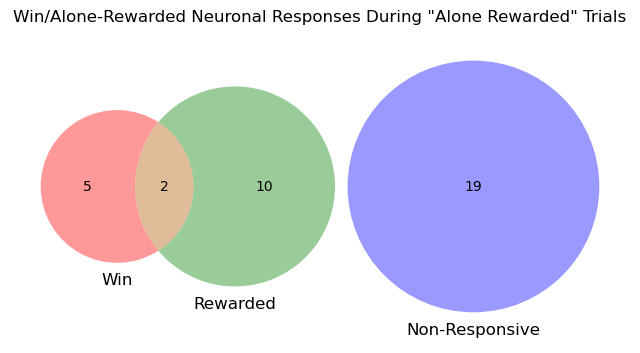

In [64]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3

venn_data = (
    reward_win_sig_counts['win'],
    reward_win_sig_counts['rewarded'],
    reward_win_sig_counts['rewarded, win'],
    reward_win_sig_counts['Non-Responsive'],
    0, 0, 0)

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(venn_data, set_labels=('Win', 'Rewarded', 'Non-Responsive'))

# Display the plot
plt.title('Win/Alone-Rewarded Neuronal Responses During "Alone Rewarded" Trials')
plt.show()
# plt.savefig('Win_Lose_Reward_Wilcoxon_Venn.png', bbox_inches='tight')

In [65]:
reward_win_df['Recording'].value_counts()

Recording
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec     17
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec     11
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec     8
Name: count, dtype: int64

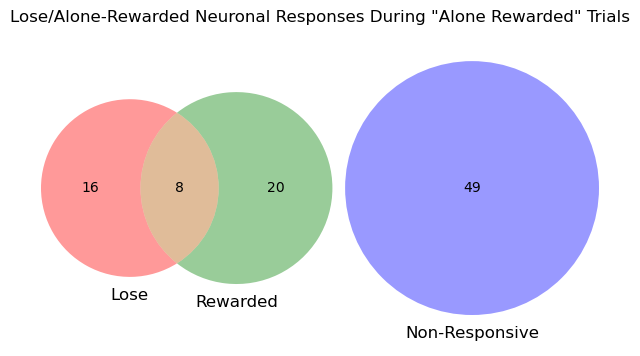

In [66]:
rewardlose_df = pd.concat([rewarded_df, lose_df])

reward_lose_df, reward_lose_events_counts = aggregate_event_data(rewardlose_df)

reward_lose_df['all_events'] = reward_lose_df.apply(
        lambda row: ', '.join(filter(None, [row['insig_events'], row['sig_events']])), axis=1)
        
reward_lose_df['all_events'] = reward_lose_df['all_events'].apply(normalize_event_string)

reward_lose_df = reward_lose_df[
    reward_lose_df['all_events'].str.contains('lose', na=False) & 
    reward_lose_df['all_events'].str.contains('rewarded', na=False)]
    
reward_lose_counts = reward_lose_df['sig_events'].value_counts()

# Rename the empty strings to 'non-responsive'
reward_lose_sig_counts = reward_lose_counts.rename(index={'': 'Non-Responsive'})

venn_data = (
    reward_lose_sig_counts['lose'],
    reward_lose_sig_counts['rewarded'],
    reward_lose_sig_counts['lose, rewarded'],
    reward_lose_sig_counts['Non-Responsive'],
    0, 0, 0)

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(venn_data, set_labels=('Lose', 'Rewarded', 'Non-Responsive'))

# Display the plot
plt.title('Lose/Alone-Rewarded Neuronal Responses During "Alone Rewarded" Trials')
plt.show()
# plt.savefig('Win_Lose_Reward_Wilcoxon_Venn.png', bbox_inches='tight')

In [67]:
reward_lose_df['Recording'].value_counts()

Recording
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec    27
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec     20
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec     18
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec     17
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec     11
Name: count, dtype: int64

In [69]:
reward_lose_df['sig_events'].value_counts()

sig_events
                  49
rewarded          20
lose              16
lose, rewarded     8
Name: count, dtype: int64

In [70]:
reward_lose_sig_df = reward_lose_df[reward_lose_df['sig_events'] == 'lose, rewarded']

In [71]:
reward_lose_sig_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events,all_events
19,20230618_100636_standard_comp_to_omission_D2_s...,1-4,103,"lose, rewarded",,,"lose, rewarded","lose, rewarded"
23,20230618_100636_standard_comp_to_omission_D2_s...,1-4,99,"lose, rewarded",,,"lose, rewarded","lose, rewarded"
26,20230618_100636_standard_comp_to_omission_D2_s...,1-4,19,"lose, rewarded",,,"lose, rewarded","lose, rewarded"
82,20230621_111240_standard_comp_to_omission_D5_s...,1-4,17,"lose, rewarded",,,"lose, rewarded","lose, rewarded"
84,20230621_111240_standard_comp_to_omission_D5_s...,1-4,6,"lose, rewarded",,,"lose, rewarded","lose, rewarded"
86,20230621_111240_standard_comp_to_omission_D5_s...,1-4,84,"lose, rewarded",,,"lose, rewarded","lose, rewarded"
96,20230621_111240_standard_comp_to_omission_D5_s...,1-4,89,"lose, rewarded",,,"lose, rewarded","lose, rewarded"
100,20230621_111240_standard_comp_to_omission_D5_s...,1-4,87,lose,rewarded,,"lose, rewarded","lose, rewarded"


# Both Rewarded Trials

In [33]:
cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'both_rewarded'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 103 is unsorted & has 512 spikes
Unit 103 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 96 is unsorted & has 5811 spikes
Unit 96 will be deleted
Unit 95 is unsorted & has 6458 spikes
Unit 95 will be deleted
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4

In [34]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [35]:
both_rewarded_df = spike_analysis.wilcox_baseline_v_event_collection('both_rewarded', 10, 10, plot=False)
win_df = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10, plot=False)
lose_df = spike_analysis.wilcox_baseline_v_event_collection('lose', 10, 10, plot=False)

Wilcoxon can't be done on 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec win, because <6 samples
Wilcoxon can't be done on 20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4_t3b3L_box1_merged.rec win, because <6 samples
Wilcoxon can't be done on 20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4_t3b3L_box1_merged.rec win, because <6 samples
Wilcoxon can't be done on 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec lose, because <6 samples
Wilcoxon can't be done on 20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec lose, because <6 samples
Wilcoxon can't be done on 20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged.rec lose, because <6 samples


In [36]:
brwinlose_df = pd.concat([both_rewarded_df, win_df, lose_df])

br_win_lose_df, br_win_lose_counts = aggregate_event_data(brwinlose_df)

In [37]:
br_win_lose_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events
0,20230622_110832_standard_comp_to_both_rewarded...,1-1,9,,,"lose, both_rewarded",
1,20230622_110832_standard_comp_to_both_rewarded...,1-1,24,,,"lose, both_rewarded",
2,20230622_110832_standard_comp_to_both_rewarded...,1-1,76,,,"lose, both_rewarded",
3,20230622_110832_standard_comp_to_both_rewarded...,1-1,10,,,"lose, both_rewarded",
4,20230622_110832_standard_comp_to_both_rewarded...,1-1,94,,,"lose, both_rewarded",
...,...,...,...,...,...,...,...
116,20230625_112913_standard_comp_to_both_rewarded...,1-4,39,both_rewarded,,lose,both_rewarded
117,20230625_112913_standard_comp_to_both_rewarded...,1-4,17,,,"lose, both_rewarded",
118,20230625_112913_standard_comp_to_both_rewarded...,1-4,15,,,"lose, both_rewarded",
119,20230625_112913_standard_comp_to_both_rewarded...,1-4,27,both_rewarded,,lose,both_rewarded


In [38]:
br_win_lose_df['all_events'] = br_win_lose_df.apply(
        lambda row: ', '.join(filter(None, [row['insig_events'], row['sig_events']])), axis=1)

In [39]:
br_win_lose_df['all_events'] = br_win_lose_df['all_events'].apply(normalize_event_string)

br_win_df = br_win_lose_df[
    br_win_lose_df['all_events'].str.contains('both_rewarded', na=False) & 
    br_win_lose_df['all_events'].str.contains('win', na=False)]

br_lose_df = br_win_lose_df[
    br_win_lose_df['all_events'].str.contains('both_rewarded', na=False) & 
    br_win_lose_df['all_events'].str.contains('lose', na=False)]

In [40]:
br_win_lose_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events,all_events
0,20230622_110832_standard_comp_to_both_rewarded...,1-1,9,,,"lose, both_rewarded",,"both_rewarded, lose"
1,20230622_110832_standard_comp_to_both_rewarded...,1-1,24,,,"lose, both_rewarded",,"both_rewarded, lose"
2,20230622_110832_standard_comp_to_both_rewarded...,1-1,76,,,"lose, both_rewarded",,"both_rewarded, lose"
3,20230622_110832_standard_comp_to_both_rewarded...,1-1,10,,,"lose, both_rewarded",,"both_rewarded, lose"
4,20230622_110832_standard_comp_to_both_rewarded...,1-1,94,,,"lose, both_rewarded",,"both_rewarded, lose"
...,...,...,...,...,...,...,...,...
116,20230625_112913_standard_comp_to_both_rewarded...,1-4,39,both_rewarded,,lose,both_rewarded,"both_rewarded, lose"
117,20230625_112913_standard_comp_to_both_rewarded...,1-4,17,,,"lose, both_rewarded",,"both_rewarded, lose"
118,20230625_112913_standard_comp_to_both_rewarded...,1-4,15,,,"lose, both_rewarded",,"both_rewarded, lose"
119,20230625_112913_standard_comp_to_both_rewarded...,1-4,27,both_rewarded,,lose,both_rewarded,"both_rewarded, lose"


In [41]:
br_win_lose_df['all_events'].value_counts()

all_events
both_rewarded, win     75
both_rewarded, lose    46
Name: count, dtype: int64

In [42]:
br_win_counts = br_win_df['sig_events'].value_counts()
# Rename the empty strings to 'non-responsive'
br_win_counts = br_win_counts.rename(index={'': 'Non-Responsive'})

br_lose_counts = br_lose_df['sig_events'].value_counts()
# Rename the empty strings to 'non-responsive'
br_lose_counts = br_lose_counts.rename(index={'': 'Non-Responsive'})

In [43]:
br_win_counts

sig_events
Non-Responsive        40
both_rewarded         15
both_rewarded, win    14
win                    6
Name: count, dtype: int64

In [44]:
br_lose_counts

sig_events
Non-Responsive         21
both_rewarded          17
both_rewarded, lose     6
lose                    2
Name: count, dtype: int64

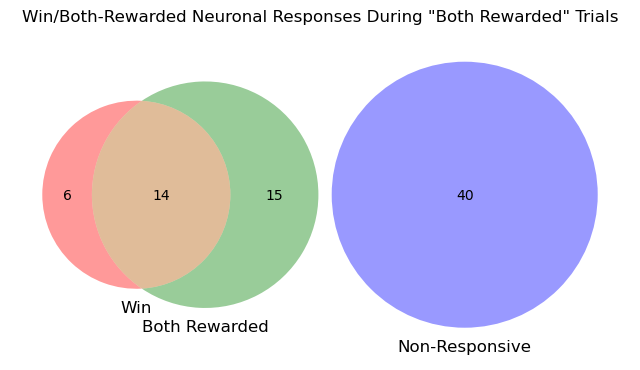

In [45]:
venn_data = (
    br_win_counts['win'],
    br_win_counts['both_rewarded'],
    br_win_counts['both_rewarded, win'],
    br_win_counts['Non-Responsive'],
    0, 0, 0)

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(venn_data, set_labels=('Win', 'Both Rewarded', 'Non-Responsive'))

# Display the plot
plt.title('Win/Both-Rewarded Neuronal Responses During "Both Rewarded" Trials')
plt.show()
# plt.savefig('Win_Lose_Reward_Wilcoxon_Venn.png', bbox_inches='tight')

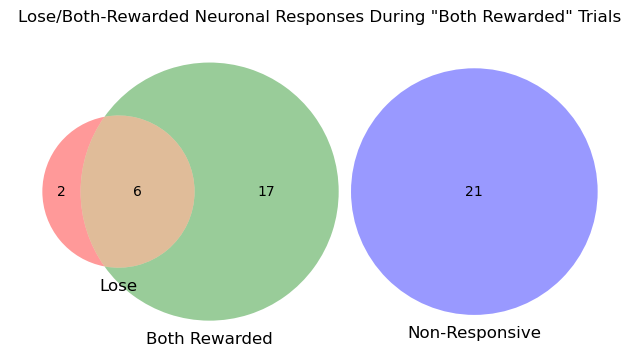

In [46]:
venn_data = (
    br_lose_counts['lose'],
    br_lose_counts['both_rewarded'],
    br_lose_counts['both_rewarded, lose'],
    br_lose_counts['Non-Responsive'],
    0, 0, 0)

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(venn_data, set_labels=('Lose', 'Both Rewarded', 'Non-Responsive'))

# Display the plot
plt.title('Lose/Both-Rewarded Neuronal Responses During "Both Rewarded" Trials')
plt.show()
# plt.savefig('Win_Lose_Reward_Wilcoxon_Venn.png', bbox_inches='tight')

In [47]:
br_win_df['Recording'].value_counts()

Recording
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec    32
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec    27
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged.rec    16
Name: count, dtype: int64

In [48]:
br_lose_df['Recording'].value_counts()

Recording
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4_t3b3L_box1_merged.rec    18
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4_t3b3L_box1_merged.rec    15
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec    13
Name: count, dtype: int64

In [72]:
br_lose_sig_df = br_lose_df[br_lose_df['sig_events'] == 'both_rewarded, lose']

In [73]:
br_win_sig_df = br_win_df[br_win_df['sig_events'] == 'both_rewarded, win']

In [74]:
br_lose_sig_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events,all_events
75,20230624_105855_standard_comp_to_both_rewarded...,1-4,25,lose,both_rewarded,,"both_rewarded, lose","both_rewarded, lose"
77,20230624_105855_standard_comp_to_both_rewarded...,1-4,73,lose,both_rewarded,,"both_rewarded, lose","both_rewarded, lose"
106,20230625_112913_standard_comp_to_both_rewarded...,1-4,52,lose,both_rewarded,,"both_rewarded, lose","both_rewarded, lose"
107,20230625_112913_standard_comp_to_both_rewarded...,1-4,60,lose,both_rewarded,,"both_rewarded, lose","both_rewarded, lose"
112,20230625_112913_standard_comp_to_both_rewarded...,1-4,99,"lose, both_rewarded",,,"both_rewarded, lose","both_rewarded, lose"
120,20230625_112913_standard_comp_to_both_rewarded...,1-4,11,"lose, both_rewarded",,,"both_rewarded, lose","both_rewarded, lose"


In [75]:
br_win_sig_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events,all_events
17,20230622_110832_standard_comp_to_both_rewarded...,1-2,33,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
20,20230622_110832_standard_comp_to_both_rewarded...,1-2,39,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
25,20230622_110832_standard_comp_to_both_rewarded...,1-2,74,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
26,20230622_110832_standard_comp_to_both_rewarded...,1-2,37,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
29,20230622_110832_standard_comp_to_both_rewarded...,1-2,23,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
34,20230622_110832_standard_comp_to_both_rewarded...,1-2,51,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
41,20230624_105855_standard_comp_to_both_rewarded...,1-2,37,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
42,20230624_105855_standard_comp_to_both_rewarded...,1-2,3,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
48,20230624_105855_standard_comp_to_both_rewarded...,1-2,128,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
51,20230624_105855_standard_comp_to_both_rewarded...,1-2,39,"win, both_rewarded",,,"both_rewarded, win","both_rewarded, win"
